In [5]:
!pip3 install tf-nightly
!pip3 install pydotplus
!pip3 install keras
!pip3 install scikit-learn

In [50]:
# Importing the necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# Initialize the CNN
classifier = Sequential()

# First convolution layer
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Second convolution layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Third convolution layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.25))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Loading the training set
print("loaded training set")
training_set = train_datagen.flow_from_directory('data/training_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

# Loading the test set
print("loaded test set")
test_set = test_datagen.flow_from_directory('data/test_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

# Training the classifier
classifier.fit(training_set, steps_per_epoch = 18, epochs = 50, validation_data = test_set, validation_steps = 2000)


loaded training set
Found 601 images belonging to 2 classes.
loaded test set
Found 9424 images belonging to 2 classes.
Epoch 1/50
18/18 [==============================] - 20s 1s/step - loss: 0.8217 - accuracy: 0.4921 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
18/18 [==============================] - 3s 187ms/step - loss: 0.6933 - accuracy: 0.5325
Epoch 3/50
18/18 [==============================] - 4s 205ms/step - loss: 0.6946 - accuracy: 0.4728
Epoch 4/50
18/18 [==============================] - 3s 189ms/step - loss: 0.6928 - accuracy: 0.5255
Epoch 5/50
18/18 [==============================] - 4s 202ms/step - loss: 0.6902 - accuracy: 0.5255
Epoch 6/50
18/18 [==============================] - 4s 237ms/step - loss: 0.6898 - accuracy: 0.5466
Epoch 7/50
18/18 [==============================] - 4s 201ms/step - loss: 0.6919 - accuracy: 0.5149
Epoch 8/50
18/18 [==============================] - 4s 194ms/step - loss: 0.6832 - accuracy: 0.5395
Epoch 9/50
18/18 [=======================

In [21]:
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)       

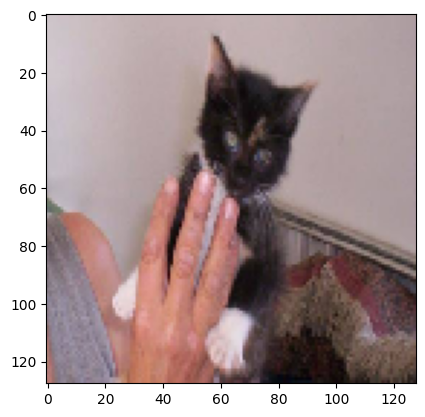

1/1 [==============================] - 0s 56ms/step


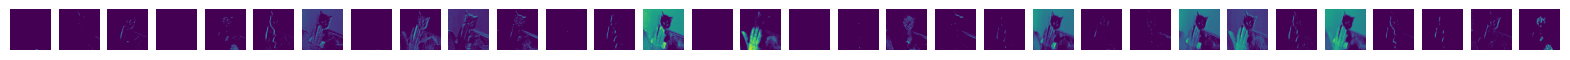

In [22]:
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Choose an image from the test set
test_image = test_set[0][0][0]
plt.imshow(test_image)
plt.show()

# Reshape the image
test_image = np.expand_dims(test_image, axis=0)

# Define a new Model, where we will input an image and we will output 
# the activations of the first conv layer for this image
layer_outputs = [layer.output for layer in classifier.layers[:2]] # get the outputs of the first conv layer
activation_model = Model(inputs=classifier.input, outputs=layer_outputs) 

# Get the feature maps
feature_maps = activation_model.predict(test_image)

# Plot the first conv layer features
n_filters = feature_maps[0].shape[-1]

fig, axs = plt.subplots(1,n_filters, figsize=(20,20))

for i in range(n_filters):
    axs[i].imshow(feature_maps[0][0, :, :, i], cmap='viridis')
    axs[i].axis('off')

plt.show()

1/1 [==============================] - 0s 69ms/step


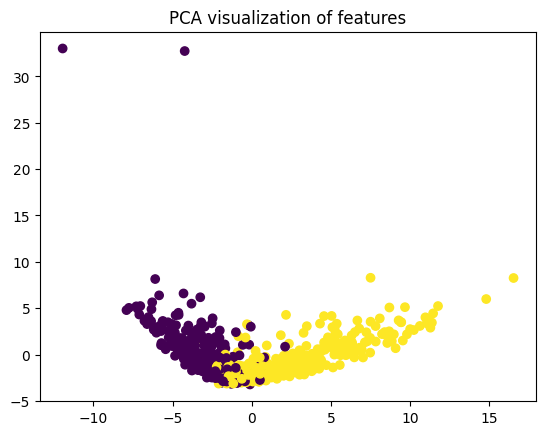

In [51]:
# Get the output of the penultimate Dense layer
layer_outputs = classifier.layers[-2].output
model_penultimate = Model(inputs=classifier.input, outputs=layer_outputs)

# We need to extract features for each image in our dataset. As we have used a generator,
# we need to loop over the generator.
features = []
labels = []
for i in range(len(training_set)):
    images, label = training_set[i]
    pred = model_penultimate.predict(images)
    features.extend(pred)
    labels.extend(label)

# Convert to numpy arrays
features_penultimate = np.array(features)
labels = np.array(labels)

# Perform PCA or t-SNE
pca = PCA(n_components=2)
result = pca.fit_transform(features_penultimate)

# Plot the results
plt.scatter(result[:, 0], result[:, 1], c=labels, cmap='viridis')
plt.title('PCA visualization of features')
plt.show()



 Each point in the scatter plot represents an image, and the color of the point indicates its label (yellow for cats and purple for dogs).

 The purpose of the visualization is to see if the CNN is able to learn meaningful representations of the images that allow it to distinguish between cats and dogs. The hope is that the features learned by the CNN will cluster the points of the same class (i.e., yellow or purple dots) together while separating the points of different classes.

In [32]:
from keras.utils import load_img
import numpy as np


# Load the image
test_image = load_img('data/test_set/dogs/dog.4009.jpg', target_size = (128, 128))


# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
test_image = np.expand_dims(test_image, axis = 0)

# Normalize the image
test_image = test_image / 255.0

# Use the model to make a prediction
# Assuming classifier is already defined
result = classifier.predict(test_image)

# The result will be a number between 0 and 1 due to the sigmoid activation function in the output layer. 
# You can convert this number to a binary label like so:
prediction = 'dog' if result[0][0] > 0.5 else 'cat'

print(prediction)

1/1 [==============================] - 0s 13ms/step
dog


In [49]:
import itertools

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# Initialize the CNN
classifier_two = Sequential()

# First convolution layer
classifier_two.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
classifier_two.add(MaxPooling2D(pool_size = (2, 2)))
classifier_two.add(Dropout(0.25))

# Second convolution layer
classifier_two.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_two.add(MaxPooling2D(pool_size = (2, 2)))
classifier_two.add(Dropout(0.25))

# Third convolution layer
classifier_two.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_two.add(MaxPooling2D(pool_size = (2, 2)))
classifier_two.add(Dropout(0.25))

# Flattening
classifier_two.add(Flatten())

# Full connection
classifier_two.add(Dense(units = 128, activation = 'relu'))
classifier_two.add(Dropout(0.5))
classifier_two.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the CNN
classifier_two.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Data augmentation
train_datagen_two = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen_two = ImageDataGenerator(rescale = 1./255)

# Loading the training set
print("loaded training set")
training_set = train_datagen.flow_from_directory('data/training_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

print("loaded augmented training set")
augmented_training_set = train_datagen.flow_from_directory('data/augmented_training_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

# Combine both training sets
combined_training_set = itertools.chain(training_set, augmented_training_set)


# Loading the test set
print("loaded test set")
test_set = test_datagen.flow_from_directory('data/test_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

# Training the classifier
classifier_two.fit(combined_training_set, steps_per_epoch = 18, epochs = 50, validation_data = test_set, validation_steps = 2000)


loaded training set
Found 601 images belonging to 2 classes.
loaded augmented training set
Found 795 images belonging to 2 classes.
loaded test set
Found 9424 images belonging to 2 classes.
Epoch 1/50
18/18 [==============================] - 19s 1s/step - loss: 0.8590 - accuracy: 0.5052 - val_loss: 0.6929 - val_accuracy: 0.5149
Epoch 2/50
18/18 [==============================] - 3s 184ms/step - loss: 0.6938 - accuracy: 0.4517
Epoch 3/50
18/18 [==============================] - 3s 181ms/step - loss: 0.6930 - accuracy: 0.5185
Epoch 4/50
18/18 [==============================] - 3s 179ms/step - loss: 0.6935 - accuracy: 0.5448
Epoch 5/50
18/18 [==============================] - 3s 180ms/step - loss: 0.6906 - accuracy: 0.5466
Epoch 6/50
18/18 [==============================] - 3s 183ms/step - loss: 0.6752 - accuracy: 0.5747
Epoch 7/50
18/18 [==============================] - 3s 180ms/step - loss: 0.6960 - accuracy: 0.5395
Epoch 8/50
18/18 [==============================] - 3s 179ms/step - lo

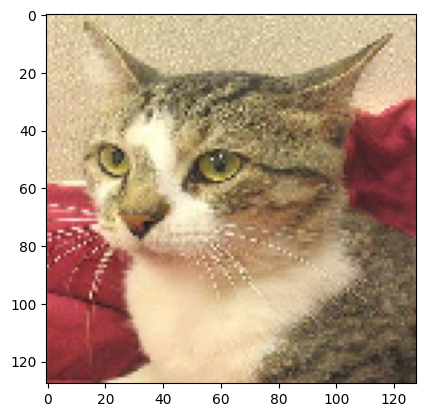

1/1 [==============================] - 0s 24ms/step


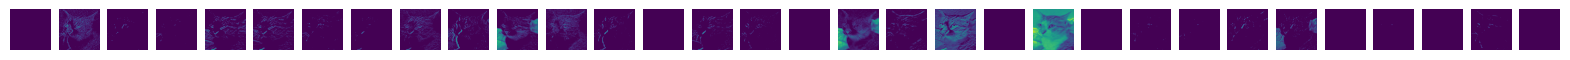

In [30]:
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Choose an image from the test set
test_image = test_set[0][0][0]
plt.imshow(test_image)
plt.show()

# Reshape the image
test_image = np.expand_dims(test_image, axis=0)

# Define a new Model, where we will input an image and we will output 
# the activations of the first conv layer for this image
layer_outputs = [layer.output for layer in classifier_two.layers[:2]] # get the outputs of the first conv layer
activation_model = Model(inputs=classifier_two.input, outputs=layer_outputs) 

# Get the feature maps
feature_maps = activation_model.predict(test_image)

# Plot the first conv layer features
n_filters = feature_maps[0].shape[-1]

fig, axs = plt.subplots(1,n_filters, figsize=(20,20))

for i in range(n_filters):
    axs[i].imshow(feature_maps[0][0, :, :, i], cmap='viridis')
    axs[i].axis('off')

plt.show()

1/1 [==============================] - 0s 70ms/step


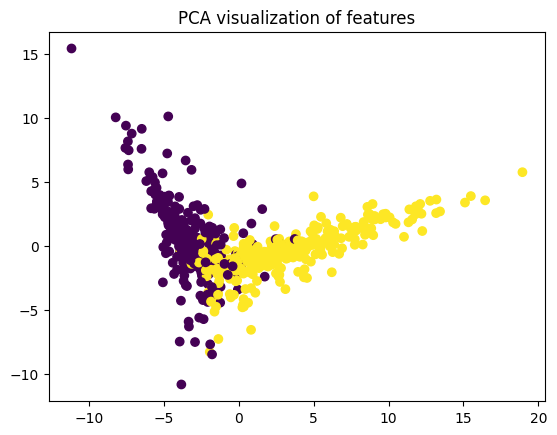

In [52]:
# Get the output of the penultimate Dense layer
layer_outputs = classifier_two.layers[-2].output
model_penultimate = Model(inputs=classifier_two.input, outputs=layer_outputs)

# We need to extract features for each image in our dataset. As we have used a generator,
# we need to loop over the generator.
features = []
labels = []
for i in range(len(training_set)):
    images, label = training_set[i]
    pred = model_penultimate.predict(images)
    features.extend(pred)
    labels.extend(label)

# Convert to numpy arrays
features_penultimate = np.array(features)
labels = np.array(labels)

# Perform PCA or t-SNE
pca = PCA(n_components=2)
result = pca.fit_transform(features_penultimate)

# Plot the results
plt.scatter(result[:, 0], result[:, 1], c=labels, cmap='viridis')
plt.title('PCA visualization of features')
plt.show()

In [45]:
from keras.utils import load_img
import numpy as np


# Load the image
test_image = load_img('data/different_styles/dogs/abstractdog.jpg', target_size = (128, 128))


# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
test_image = np.expand_dims(test_image, axis = 0)

# Normalize the image
test_image = test_image / 255.0

# Use the model to make a prediction
# Assuming classifier is already defined
result = classifier.predict(test_image)
result_two = classifier_two.predict(test_image)

print(result)
print(result_two)
# The result will be a number between 0 and 1 due to the sigmoid activation function in the output layer. 
# You can convert this number to a binary label like so:
prediction = 'dog' if result[0][0] > 0.5 else 'cat'

print(prediction)

1/1 [==============================] - 0s 16ms/step
[[0.94300926]]
[[0.9889232]]
dog


In [48]:
import itertools

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# Initialize the CNN
classifier_three = Sequential()

# First convolution layer
classifier_three.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
classifier_three.add(MaxPooling2D(pool_size = (2, 2)))
classifier_three.add(Dropout(0.25))

# Second convolution layer
classifier_three.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier_three.add(MaxPooling2D(pool_size = (2, 2)))
classifier_three.add(Dropout(0.25))

# Third convolution layer
classifier_three.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier_three.add(MaxPooling2D(pool_size = (2, 2)))
classifier_three.add(Dropout(0.25))

# Flattening
classifier_three.add(Flatten())

# Full connection
classifier_three.add(Dense(units = 128, activation = 'relu'))
classifier_three.add(Dropout(0.5))
classifier_three.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the CNN
classifier_three.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Data augmentation
train_datagen_three = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen_three = ImageDataGenerator(rescale = 1./255)

# Loading the training set
print("loaded training set")
training_set = train_datagen.flow_from_directory('data/training_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

print("loaded augmented training set")
augmented_training_set = train_datagen.flow_from_directory('data/augmented_training_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

# Combine both training sets
combined_training_set = itertools.chain(training_set, augmented_training_set)


print("loaded stylized training set")
stylized_training_set = train_datagen.flow_from_directory('data/stylized_training_set/', target_size = (128, 128), batch_size = 32, class_mode = 'binary')


combined_training_set = itertools.chain(combined_training_set, stylized_training_set)

# Loading the test set
print("loaded test set")
test_set = test_datagen.flow_from_directory('data/test_set', target_size = (128, 128), batch_size = 32, class_mode = 'binary')

# Training the classifier
classifier_three.fit(combined_training_set, steps_per_epoch = 18, epochs = 50, validation_data = test_set, validation_steps = 2000)


loaded training set
Found 601 images belonging to 2 classes.
loaded augmented training set
Found 795 images belonging to 2 classes.
loaded stylized training set
Found 5122 images belonging to 2 classes.
loaded test set
Found 9424 images belonging to 2 classes.
Epoch 1/50
18/18 [==============================] - 19s 1s/step - loss: 0.9079 - accuracy: 0.5035 - val_loss: 0.6922 - val_accuracy: 0.5022
Epoch 2/50
18/18 [==============================] - 3s 184ms/step - loss: 0.6958 - accuracy: 0.5044
Epoch 3/50
18/18 [==============================] - 3s 181ms/step - loss: 0.6922 - accuracy: 0.5290
Epoch 4/50
18/18 [==============================] - 3s 182ms/step - loss: 0.6904 - accuracy: 0.5272
Epoch 5/50
18/18 [==============================] - 3s 183ms/step - loss: 0.6910 - accuracy: 0.5026
Epoch 6/50
18/18 [==============================] - 3s 186ms/step - loss: 0.6852 - accuracy: 0.5431
Epoch 7/50
18/18 [==============================] - 3s 182ms/step - loss: 0.6689 - accuracy: 0.6169

1/1 [==============================] - 0s 77ms/step


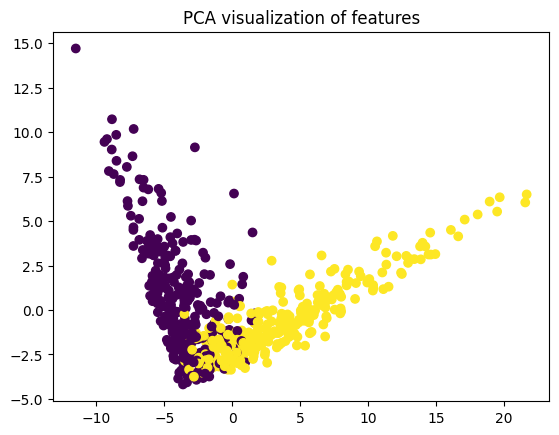

In [53]:
# Get the output of the penultimate Dense layer
layer_outputs = classifier_three.layers[-2].output
model_penultimate = Model(inputs=classifier_three.input, outputs=layer_outputs)

# We need to extract features for each image in our dataset. As we have used a generator,
# we need to loop over the generator.
features = []
labels = []
for i in range(len(training_set)):
    images, label = training_set[i]
    pred = model_penultimate.predict(images)
    features.extend(pred)
    labels.extend(label)

# Convert to numpy arrays
features_penultimate = np.array(features)
labels = np.array(labels)

# Perform PCA or t-SNE
pca = PCA(n_components=2)
result = pca.fit_transform(features_penultimate)

# Plot the results
plt.scatter(result[:, 0], result[:, 1], c=labels, cmap='viridis')
plt.title('PCA visualization of features')
plt.show()